In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v1.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v1.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v1.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v1/build.ninja...
Building extension module vlstm_fwbw_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v1...


## CUDA vLSTM forward

In [3]:
S = 16 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 8 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [4]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(0)
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [5]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [6]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [7]:
hs_pt, n_pt, m_pt, _, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [8]:
hs_pt_half, n_pt_half, m_pt_half, _, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
dQs_pt_half, dKs_pt_half, dVs_pt_half, dIgs_pt_half, dFgs_pt_half, delta_D_pt_half, delta_Dtilde_pt_half, delta_fbar_pt_half, mat_P_pt_half, mat_R_pt_half = vlstm_bw_torch_obw(
    delta_Htilde=dHs_half,
    queries=qs_half,
    keys=ks_half,
    values=vs_half,
    igate_preact=igs_half,
    fgate_preact=fgs_half,
    var_n=n_pt_half,
    var_m=m_pt_half,
)
dQs_pt_half.dtype, delta_D_pt_half.dtype

(torch.float16, torch.float16)

In [9]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
dQs_pt_bf16, dKs_pt_bf16, dVs_pt_bf16, dIgs_pt_bf16, dFgs_pt_bf16, delta_D_pt_bf16, delta_Dtilde_pt_bf16, delta_fbar_pt_bf16, mat_P_pt_bf16, mat_R_pt_bf16 = vlstm_bw_torch_obw(
    delta_Htilde=dHs_bf16,
    queries=qs_bf16,
    keys=ks_bf16,
    values=vs_bf16,
    igate_preact=igs_bf16,
    fgate_preact=fgs_bf16,
    var_n=n_pt_bf16,
    var_m=m_pt_bf16,
)
dQs_pt_bf16.dtype, delta_D_pt_bf16.dtype

(torch.bfloat16, torch.bfloat16)

In [10]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_half - dFgs_pt))}")
print(f"bw delta_D match: {torch.allclose(delta_D_pt_half.float(), delta_D_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(delta_D_pt_half - delta_D_pt))}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_bf16 - dFgs_pt))}")


====== Full -> Half ======
fw hs match: False, max diff: 0.003529071807861328
fw n match: False, max diff: 0.0019568204879760742
fw m match: True, max diff: 0.0
fw D match: False, max diff: 0.0077114105224609375
---------------------------------
bw dQs match: False, max diff: 0.01334524154663086
bw dKs match: False, max diff: 0.012964487075805664
bw dVs match: False, max diff: 0.008620262145996094
bw dIgs match: False, max diff: 0.010234355926513672
bw dFgs match: False, max diff: 0.00358426570892334
bw delta_D match: False, max diff: 0.0071953535079956055
====== Full -> bfloat16 ======
fw hs match: False, max diff: 0.048856258392333984
fw n match: False, max diff: 0.010345220565795898
fw m match: True, max diff: 0.0
fw D match: False, max diff: 0.017090797424316406
---------------------------------
bw dQs match: False, max diff: 0.09928274154663086
bw dKs match: False, max diff: 0.07937073707580566
bw dVs match: False, max diff: 0.0691671371459961
bw dIgs match: False, max diff: 0.125

In [11]:
# (hs_pt_half.float() - hs_pt) #> 4.5e-3

In [12]:
# (hs_pt_bf16.float() - hs_pt) #> 0.018

In [13]:
torch.abs(hs_pt_bf16.float() - hs_pt).max(), torch.abs(hs_pt_bf16.float() - hs_pt).mean() #> 1e-2

(tensor(0.0489, device='cuda:0'), tensor(0.0045, device='cuda:0'))

### match directly

In [14]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu, deltaDcsChunkArr_cu, deltaDcsVec_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=1, dTileThreadYIdx=7, f_acc=-0.427888, fg(1)=-0.427888
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=2, dTileThreadYIdx=7, f_acc=-0.875554, fg(2)=-0.447666
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=3, dTileThreadYIdx=7, f_acc=-1.721586, fg(3)=-0.846032
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=4, dTileThreadYIdx=7, f_acc=-2.396089, fg(4)=-0.674503
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=5, dTileThreadYIdx=7, f_acc=-3.731529, fg(5)=-1.335440
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=6, dTileThreadYIdx=7, f_acc=-4.294543, fg(6)=-0.563014
qTileIdx=0, 

In [15]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)
dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half, deltaDcsChunkArr_cu_half, deltaDcsVec_cu_half = vlstm_bw_cuda(
    mat_delta_H=dHs_half,
    mat_Q=qs_half,
    mat_K=ks_half,
    mat_V=vs_half,
    vec_igp=igs_half,
    vec_fgp=fgs_half,
    vec_n=n_cu_half,
    vec_m=m_cu_half,
)

before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=1, dTileThreadYIdx=7, f_acc=0.000000, fg(1)=0.000000
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=2, dTileThreadYIdx=7, f_acc=0.000000, fg(2)=0.000000
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=3, dTileThreadYIdx=7, f_acc=-0.285400, fg(3)=-0.285400
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=4, dTileThreadYIdx=7, f_acc=-0.285400, fg(4)=0.000000
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=5, dTileThreadYIdx=7, f_acc=-1.315674, fg(5)=-1.030273
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=6, dTileThreadYIdx=7, f_acc=-1.315674, fg(6)=0.000000
qTileIdx=0, fChunk

In [16]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)
dQs_cu_bf16, dKs_cu_bf16, dVs_cu_bf16, dIgs_cu_bf16, dFgs_cu_bf16, matC_cu_bf16, deltaDcsChunkArr_cu_bf16, deltaDcsVec_cu_bf16 = vlstm_bw_cuda(
    mat_delta_H=dHs_bf16,
    mat_Q=qs_bf16,
    mat_K=ks_bf16,
    mat_V=vs_bf16,
    vec_igp=igs_bf16,
    vec_fgp=fgs_bf16,
    vec_n=n_cu_bf16,
    vec_m=m_cu_bf16,
)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=1, dTileThreadYIdx=7, f_acc=-0.425781, fg(1)=-0.425781
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=2, dTileThreadYIdx=7, f_acc=-0.871094, fg(2)=-0.445312
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=3, dTileThreadYIdx=7, f_acc=-1.714844, fg(3)=-0.843750
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=4, dTileThreadYIdx=7, f_acc=-2.390625, fg(4)=-0.675781
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=5, dTileThreadYIdx=7, f_acc=-3.726562, fg(5)=-1.335938
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=6, dTileThreadYIdx=7, f_acc=-4.289062, fg(6)=-0.562500
qTileIdx=0,

In [17]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_half - dFgs_pt))}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_bf16 - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: True, max diff: 1.0728836059570312e-06
fw n match: True, max diff: 2.384185791015625e-07
fw m match: True, max diff: 0.0
fw D match: True, max diff: 4.76837158203125e-07
---------------------------------
bw dQs match: True, max diff: 7.62939453125e-06
bw dKs match: True, max diff: 8.58306884765625e-06
bw dVs match: True, max diff: 4.291534423828125e-06
bw dIgs match: True, max diff: 8.58306884765625e-06
bw dFgs match: True, max diff: 1.1920928955078125e-06
====== Half ======
fw hs match: False, max diff: 2.400362491607666
fw n match: False, max diff: 1.337890625
fw m match: True, max diff: 0.0
fw D match: False, max diff: 6.6529130935668945
---------------------------------
bw dQs match: False, max diff: 82.9687271118164
bw dKs match: False, max diff: 88.98515319824219
bw dVs match: False, max diff: 144.20635986328125
bw dIgs match: False, max diff: 69.5542221069336
bw dFgs match: False, max diff: 69.0958023071289
====== bfloat1

In [18]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

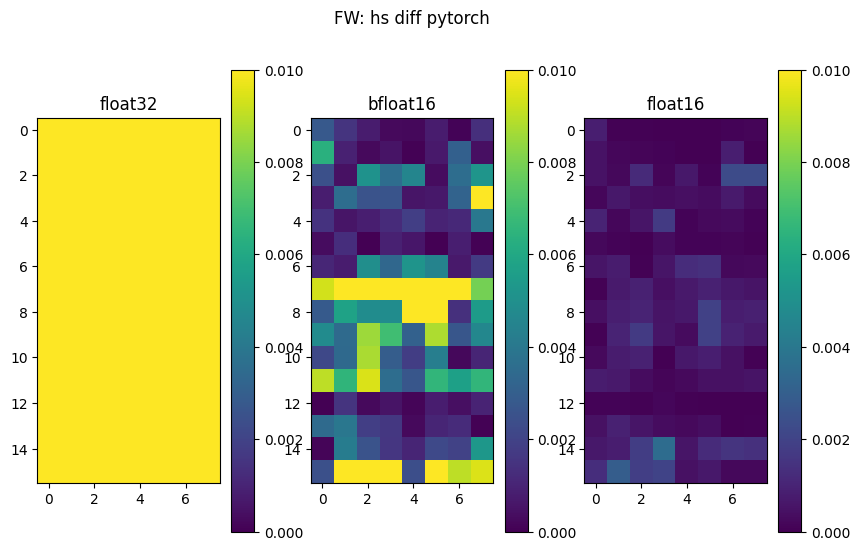

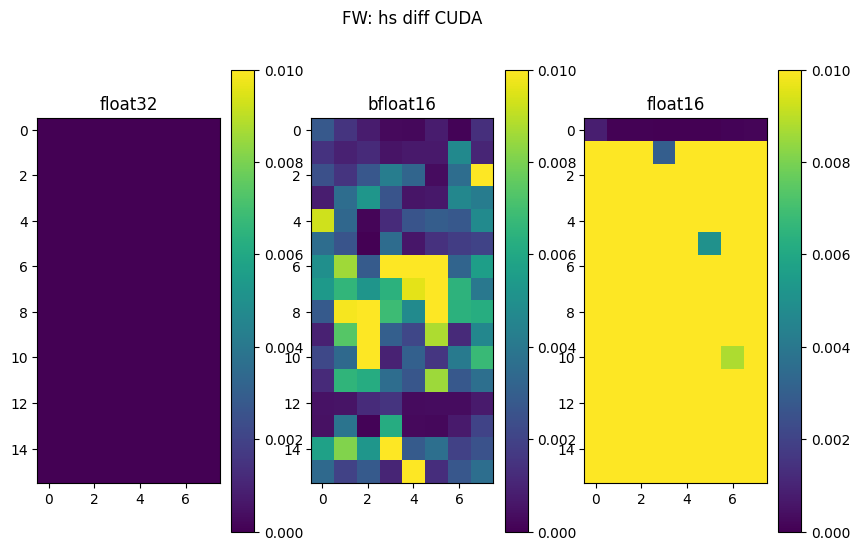

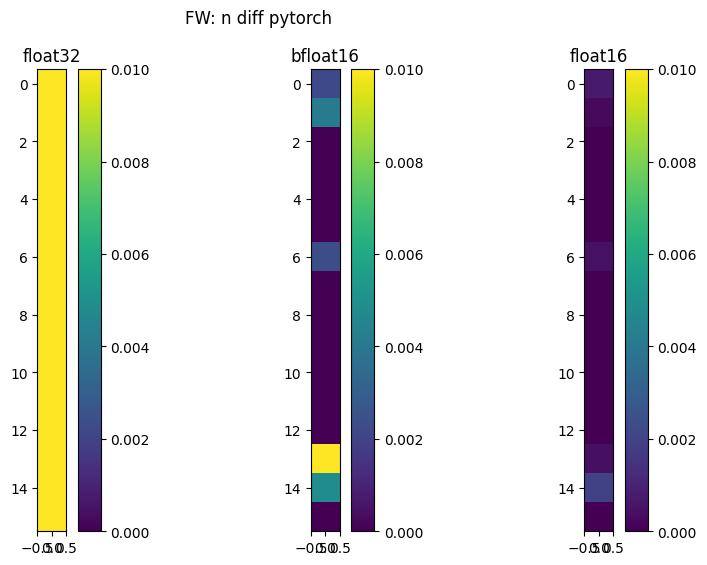

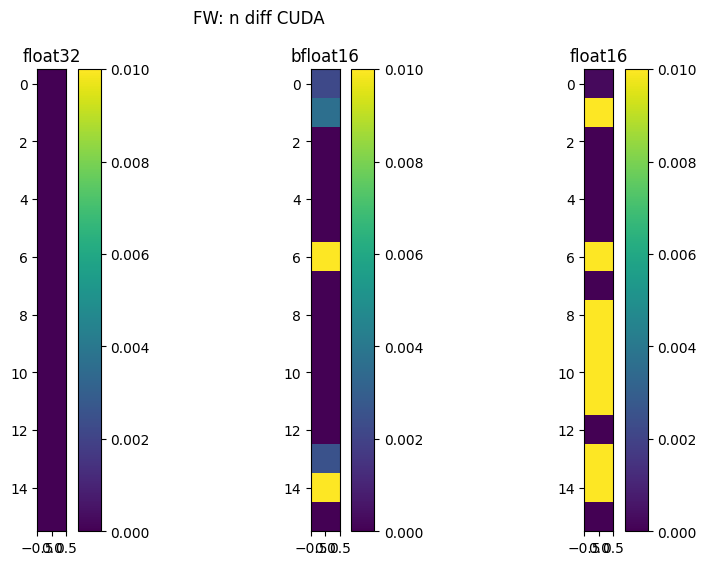

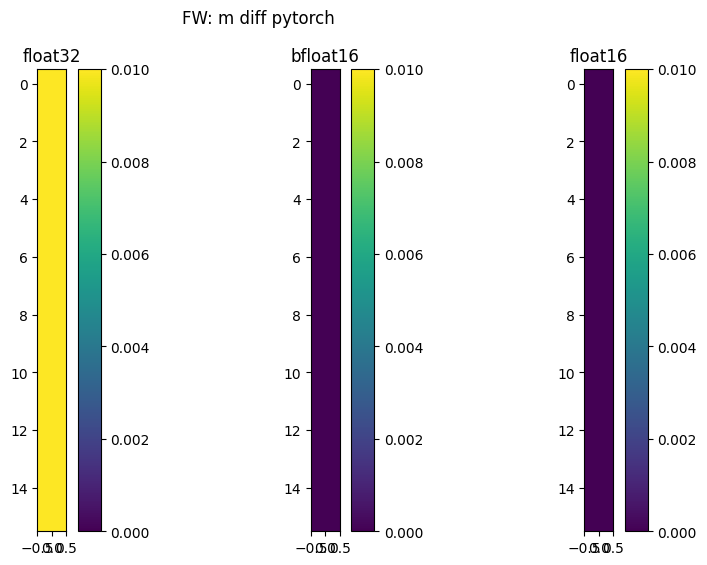

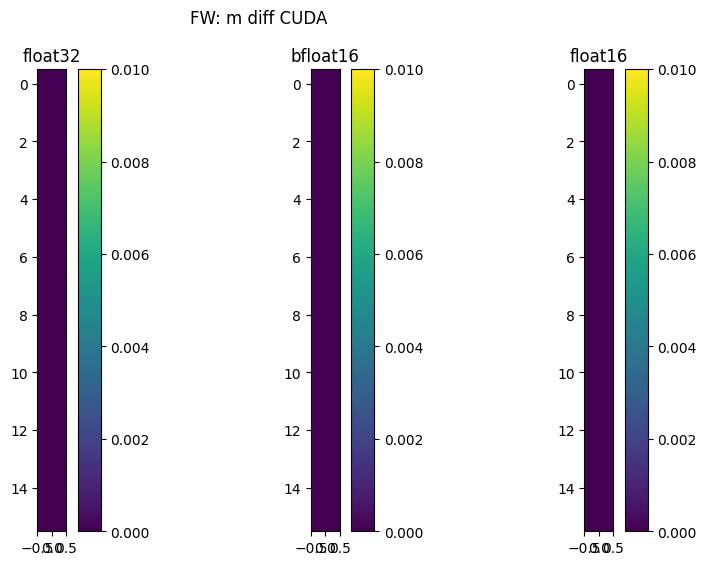

In [19]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")

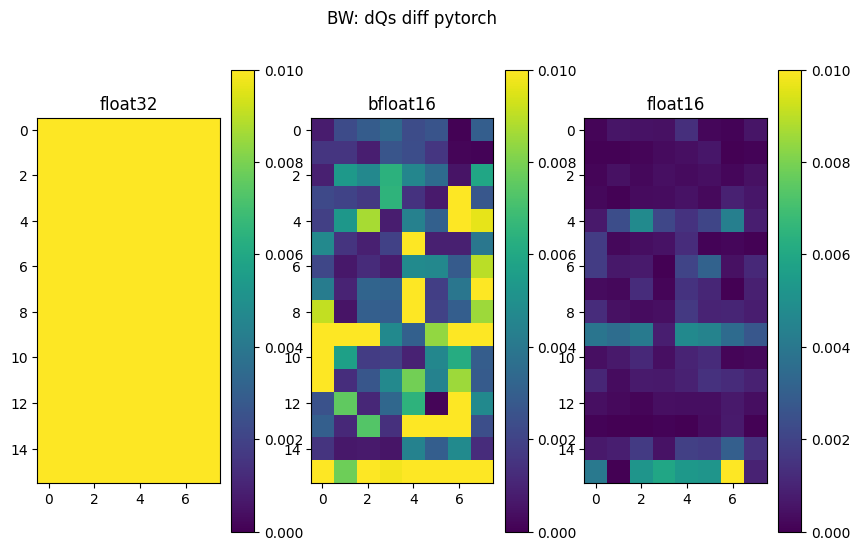

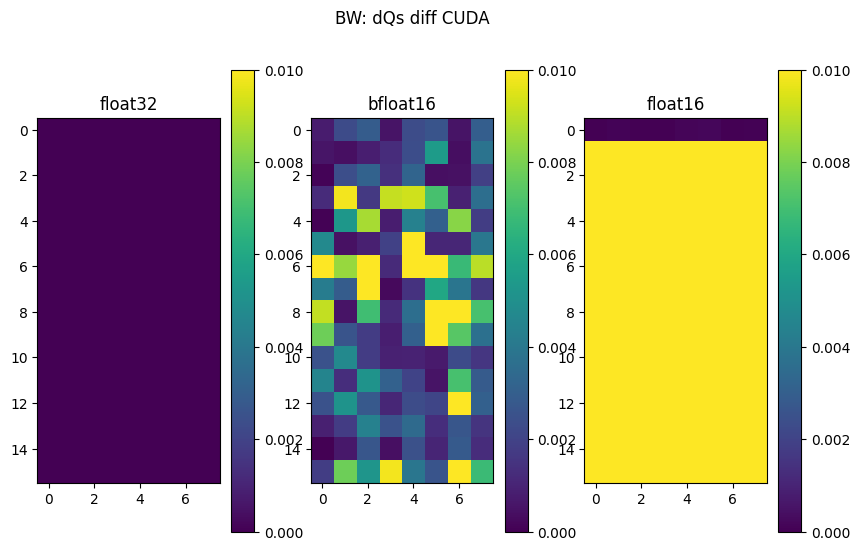

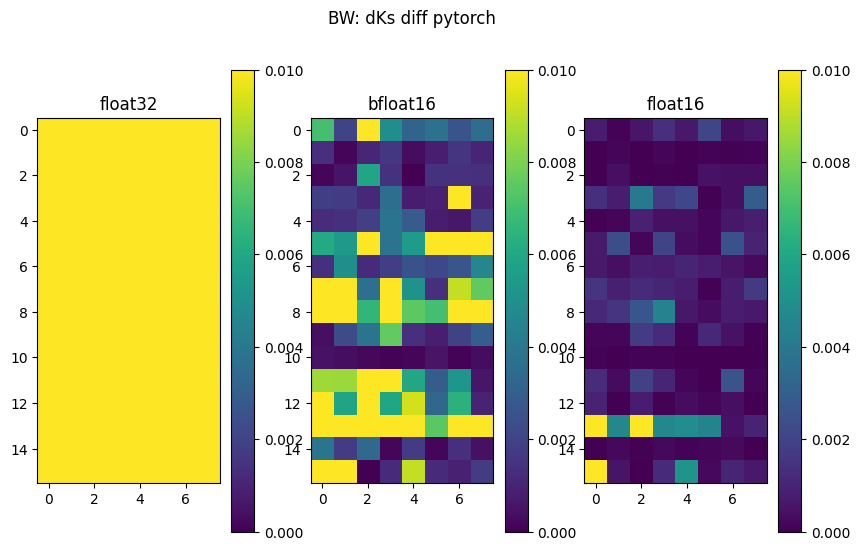

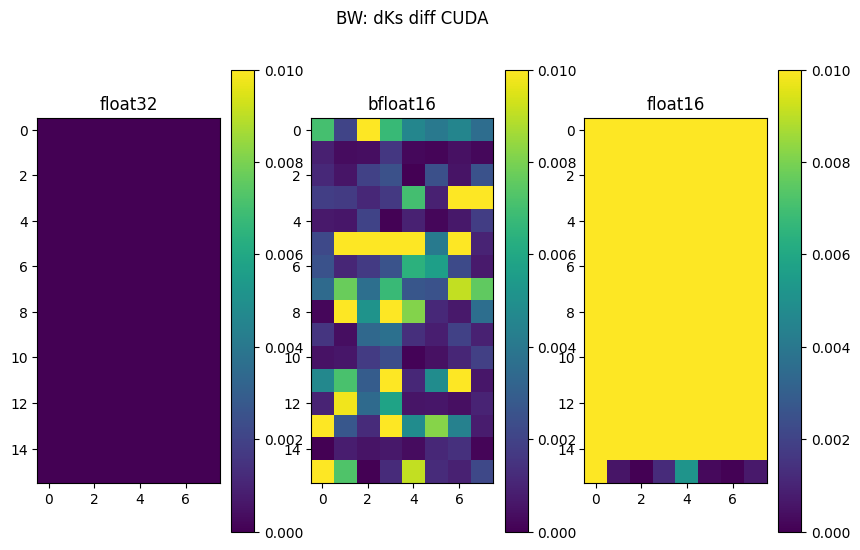

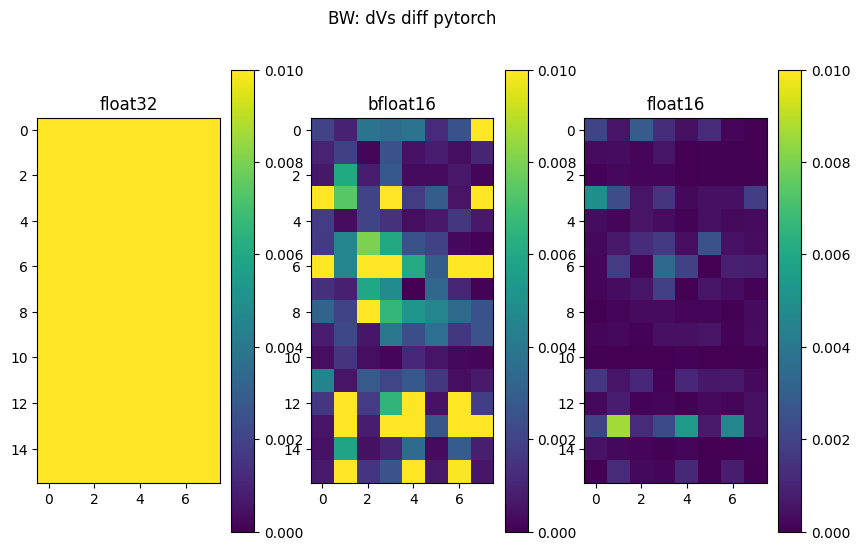

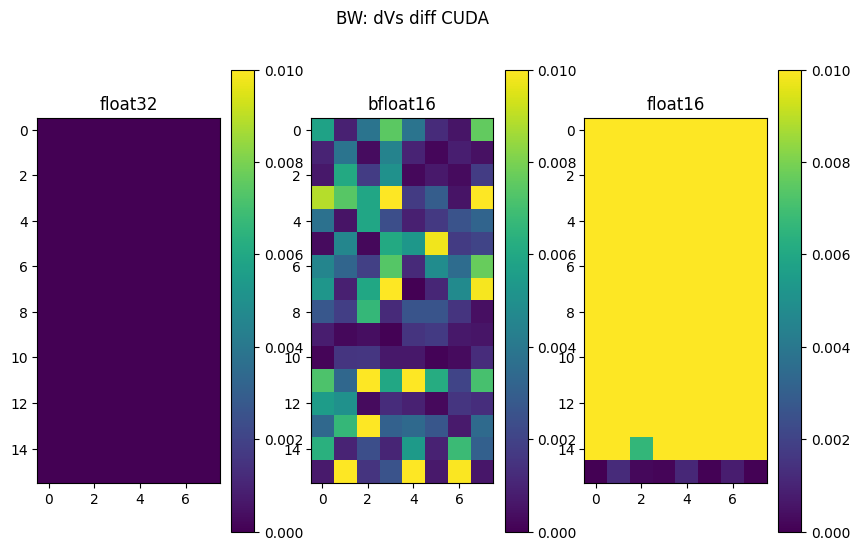

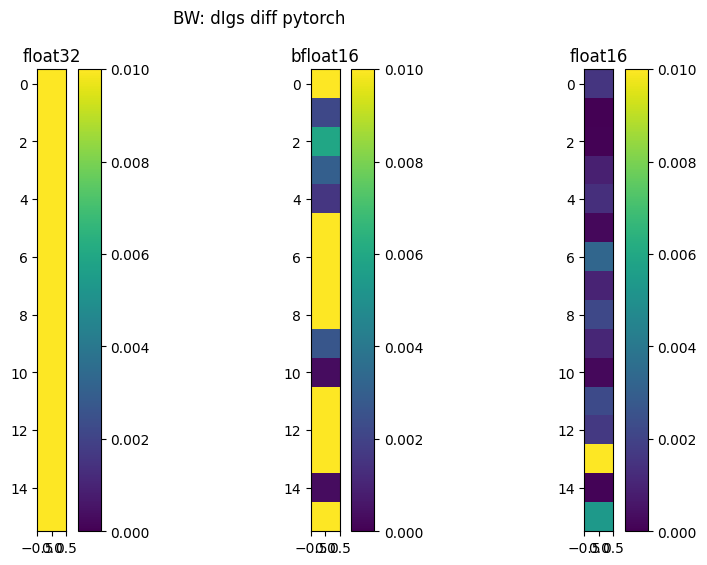

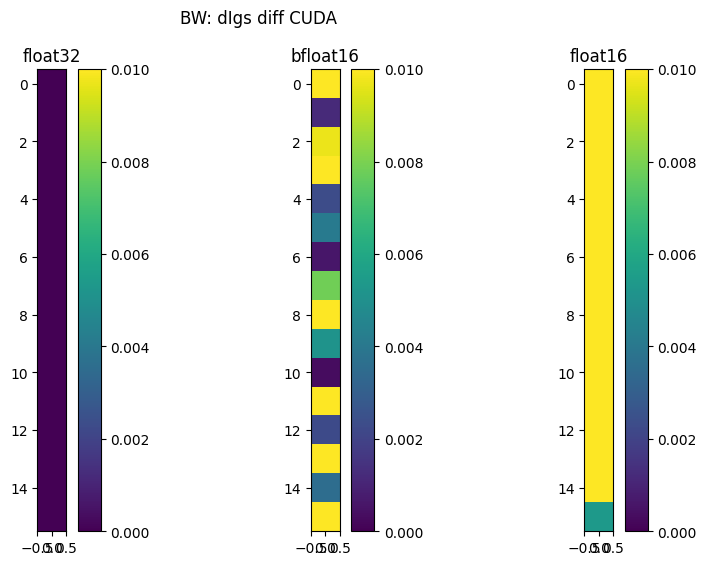

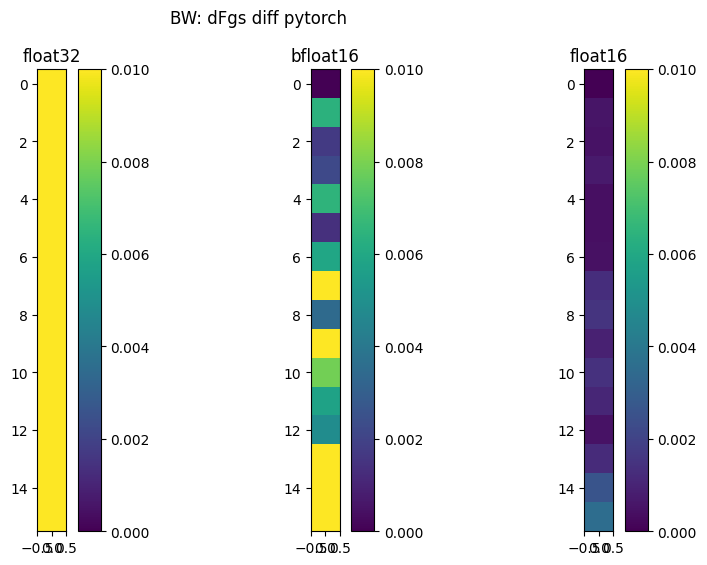

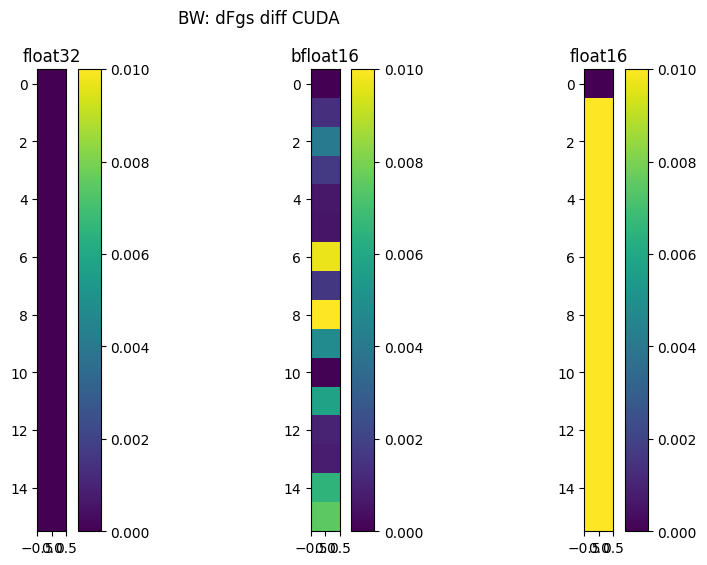

In [20]:
# bw diffs
# dQs
fig = plot_numerical_diffs(dQs_pt, 10*torch.ones_like(dQs_pt), dQs_pt_bf16, dQs_pt_half, title="BW: dQs diff pytorch")
fig = plot_numerical_diffs(dQs_pt, dQs_cu, dQs_cu_bf16, dQs_cu_half, title="BW: dQs diff CUDA")
# dKs
fig = plot_numerical_diffs(dKs_pt, 10*torch.ones_like(dKs_pt), dKs_pt_bf16, dKs_pt_half, title="BW: dKs diff pytorch")
fig = plot_numerical_diffs(dKs_pt, dKs_cu, dKs_cu_bf16, dKs_cu_half, title="BW: dKs diff CUDA")
# dVs
fig = plot_numerical_diffs(dVs_pt, 10*torch.ones_like(dVs_pt), dVs_pt_bf16, dVs_pt_half, title="BW: dVs diff pytorch")
fig = plot_numerical_diffs(dVs_pt, dVs_cu, dVs_cu_bf16, dVs_cu_half, title="BW: dVs diff CUDA")
# dIgs
fig = plot_numerical_diffs(dIgs_pt, 10*torch.ones_like(dIgs_pt), dIgs_pt_bf16, dIgs_pt_half, title="BW: dIgs diff pytorch")
fig = plot_numerical_diffs(dIgs_pt, dIgs_cu, dIgs_cu_bf16, dIgs_cu_half, title="BW: dIgs diff CUDA")
# dFgs
fig = plot_numerical_diffs(dFgs_pt, 10*torch.ones_like(dFgs_pt), dFgs_pt_bf16, dFgs_pt_half, title="BW: dFgs diff pytorch")
fig = plot_numerical_diffs(dFgs_pt, dFgs_cu, dFgs_cu_bf16, dFgs_cu_half, title="BW: dFgs diff CUDA")

### Debug float16 precision differences in cuda kernel

In [33]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 5664
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=1, dTileThreadYIdx=7, f_acc=-0.427888, fg(1)=-0.427888
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=2, dTileThreadYIdx=7, f_acc=-0.875554, fg(2)=-0.447666
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=3, dTileThreadYIdx=7, f_acc=-1.721586, fg(3)=-0.846032
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=4, dTileThreadYIdx=7, f_acc=-2.396089, fg(4)=-0.674503
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=5, dTileThreadYIdx=7, f_acc=-3.731529, fg(5)=-1.335440
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=6, dTileThreadYIdx=7, f_acc=-4.294543, fg(6)=-0.563014
qTileIdx=0, 

In [21]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=1, dTileThreadYIdx=7, f_acc=0.000000, fg(1)=0.000000
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=2, dTileThreadYIdx=7, f_acc=0.000000, fg(2)=0.000000
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=3, dTileThreadYIdx=7, f_acc=-0.285400, fg(3)=-0.285400
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=4, dTileThreadYIdx=7, f_acc=-0.285400, fg(4)=0.000000
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=5, dTileThreadYIdx=7, f_acc=-1.315674, fg(5)=-1.030273
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=6, dTileThreadYIdx=7, f_acc=-1.315674, fg(6)=0.000000
qTileIdx=0, fChunk

In [22]:
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")


====== Half ======
fw hs match: False, max diff: 2.400362491607666
fw n match: False, max diff: 1.337890625
fw m match: True, max diff: 0.0
fw D match: False, max diff: 6.6529130935668945


In [23]:
# matS = (qs @ ks.transpose(-2, -1) / (DH ** 0.5)).tril()
# matS[:,:, :, :10]

In [24]:
# (matD_cu_half - matS)[:, :, :, :10]

In [25]:
torch.nn.functional.logsigmoid(fgs_half)

tensor([[[[-0.8804],
          [-0.4277],
          [-0.4475],
          [-0.8462],
          [-0.6743],
          [-1.3359],
          [-0.5630],
          [-0.4207],
          [-0.7808],
          [-0.2096],
          [-0.5332],
          [-0.8359],
          [-1.7891],
          [-0.6030],
          [-0.1915],
          [-0.3518]]]], device='cuda:0', dtype=torch.float16)

In [26]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-0.8806],
          [-0.4279],
          [-0.4477],
          [-0.8460],
          [-0.6745],
          [-1.3354],
          [-0.5630],
          [-0.4207],
          [-0.7806],
          [-0.2096],
          [-0.5331],
          [-0.8361],
          [-1.7890],
          [-0.6032],
          [-0.1915],
          [-0.3519]]]], device='cuda:0')

In [27]:
matD_cu_half[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[ 0.0000e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,        -inf,        -inf,        -inf,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [ 0.0000e+00, -4.6313e-05,  0.0000e+00,        -inf,        -inf,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-2.8540e-01, -2.8540e-01, -2.8540e-01,  0.0000e+00,        -inf,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-2.8540e-01, -2.8540e-01, -2.8540e-01, -9.3162e-05,  0.0000e+00,        -inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-1.3154e+00, -1.3154e+00, -1.3154e+00, -1.0303e+00, -1.0303e+00,  0.0000e+00,        -inf,        -inf,  0.0000e+00,  0.0000e+00],
           [-1.3154e+00, -1.3154e+00, -1.3154e+00, -1.0303e+00, -1.0303e+00, -1.4102e-04,  0.0000e+00,        -inf,  0.0000e+00,  0.0000e+00],

### bfloat16 differences in kernel

In [28]:
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 16, DH: 8
blocksxy: 1-1, threadsxy: 4-4, shared_mem in bytes: 2976
In FW-Kernel: gdim.x: 1, gdim.y: 1, gdim.z: 1, bdim.x: 4, bdim.y: 4
In FW-Kernel: QtileDim: 8, KVtileDim: 8, TblockDim:4
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=1, dTileThreadYIdx=7, f_acc=-0.425781, fg(1)=-0.425781
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=2, dTileThreadYIdx=7, f_acc=-0.871094, fg(2)=-0.445312
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=3, dTileThreadYIdx=7, f_acc=-1.714844, fg(3)=-0.843750
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=4, dTileThreadYIdx=7, f_acc=-2.390625, fg(4)=-0.675781
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=5, dTileThreadYIdx=7, f_acc=-3.726562, fg(5)=-1.335938
qTileIdx=0, fChunkAccIterIdx=0 (<1), blockIdx.y=0, flatThreadIdx=7: i=6, dTileThreadYIdx=7, f_acc=-4.289062, fg(6)=-0.562500
qTileIdx=0,

In [29]:
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matD_pt).tril())}")

====== bfloat16 ======
fw hs match: False, max diff: 0.020809412002563477
fw n match: False, max diff: 0.012691617012023926
fw m match: True, max diff: 0.0
fw D match: False, max diff: 0.019947052001953125


In [30]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-0.8806],
          [-0.4279],
          [-0.4477],
          [-0.8460],
          [-0.6745],
          [-1.3354],
          [-0.5630],
          [-0.4207],
          [-0.7806],
          [-0.2096],
          [-0.5331],
          [-0.8361],
          [-1.7890],
          [-0.6032],
          [-0.1915],
          [-0.3519]]]], device='cuda:0')

In [31]:
matD_cu_bf16[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[  0.0000,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -0.4258,   0.0000,     -inf,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -0.8711,  -0.4453,   0.0000,     -inf,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -1.7188,  -1.2891,  -0.8438,   0.0000,     -inf,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -2.3906,  -1.9688,  -1.5156,  -0.6758,   0.0000,     -inf,     -inf,     -inf,   0.0000,   0.0000],
           [ -3.7188,  -3.2969,  -2.8594,  -2.0156,  -1.3359,   0.0000,     -inf,     -inf,   0.0000,   0.0000],
           [ -4.2812,  -3.8594,  -3.4219,  -2.5781,  -1.8984,  -0.5625,   0.0000,     -inf,   0.0000,   0.0000],
           [ -4.7188,  -4.2812,  -3.8438,  -3.0000,  -2.3125,  -0.9844,  -0.4219,   0.0000,   0.0000,   0.0000],
           [ -5.5000,  -5.0625,  -4.6250,  -3.7812,  -3.0938,  -1.7656,  -1.2031,  -0.7812,   0.

In [32]:
hs_cu_bf16, hs_pt

(tensor([[[[-2.5469e+00,  7.1484e-01,  4.9414e-01, -1.2695e-01, -1.0156e-01,  4.0430e-01, -9.0234e-01, -8.0859e-01],
           [-1.4531e+00,  4.2773e-01, -2.1484e-02, -1.1572e-01,  5.8594e-02,  2.9883e-01, -1.2891e+00,  7.4219e-02],
           [-5.0781e-01,  3.9648e-01, -1.3984e+00,  8.7109e-01,  1.1094e+00,  1.2988e-01, -2.3594e+00,  1.6406e+00],
           [ 1.9766e+00, -1.6094e+00,  7.5000e-01, -8.0078e-01,  1.2656e+00, -7.5781e-01, -1.4844e+00,  3.2188e+00],
           [ 9.3750e-01, -3.5742e-01,  1.2891e-01,  1.1406e+00,  1.2634e-02, -4.7070e-01, -4.1992e-01,  8.5449e-02],
           [ 6.9336e-02, -2.6562e-01, -3.7109e-01,  1.5747e-02, -5.1953e-01,  8.3496e-02, -1.6504e-01, -1.2695e-01],
           [ 6.4062e-01, -1.4922e+00, -1.1875e+00,  1.1250e+00,  2.5312e+00, -2.6094e+00, -8.4766e-01, -9.4531e-01],
           [-6.2109e-01,  9.5312e-01,  4.4531e-01, -2.7148e-01, -8.7891e-01,  6.8359e-01,  4.5117e-01,  1.9629e-01],
           [ 5.4688e-01,  4.1797e-01,  1.3125e+00, -7.3047e-01, 